<a href="https://colab.research.google.com/github/mo3tawesome/TweetsClassifier/blob/master/CNNvsLogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving offenseval-training-v1.tsv to offenseval-training-v1.tsv


In [2]:
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import re
from sklearn.linear_model import LogisticRegression
import numpy as np
from keras.models import Sequential
from keras import layers
import numpy as np
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


CNN


In [3]:

with open('offenseval-training-v1.tsv', 'r', encoding="utf-8") as f:
    reader = csv.reader(f, dialect='excel', delimiter='\t')
    results = [] #tsv file 0:id, 1:sentence, 2: off/not
    sentences = []
    lables = []
    for row in reader:
        results.append(row)
        sentences.append(row[1])
        lables.append(row[2])
count=0
removal_list = ["@USER","URL"]
for sentence in sentences:
  edit_string_as_list = sentence.split()
  final_list = [word for word in edit_string_as_list if word not in removal_list]
  final_string = ' '.join(final_list)
  final_string = final_string.replace("#", "")
  #final_string = re.sub("^[a-z][a-z\s]*$", "", final_string) #remove non word chars
  sentences[count]=final_string.lower()
  count+=1


sentences_train, sentences_test, y_train, y_test = train_test_split( sentences, lables, test_size=0.2, random_state=1000)

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

from keras.preprocessing.sequence import pad_sequences
maxlen = 140
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

count=0;
for i in y_train:
  if(i=="OFF"):
    y_train[count]=0
  else:
    y_train[count]=1
  count+=1
count=0;
for i in y_test:
  if(i=="OFF"):
    y_test[count]=0
  else:
    y_test[count]=1
  count+=1

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1] )) 
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1] ))

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(170, 4, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=1,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1] )) 
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1] ))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 50)           931150    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 137, 170)          34170     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 170)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1710      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 967,041
Trainable params: 967,041
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.8101
Testing Accuracy:  0.7622


In [0]:

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

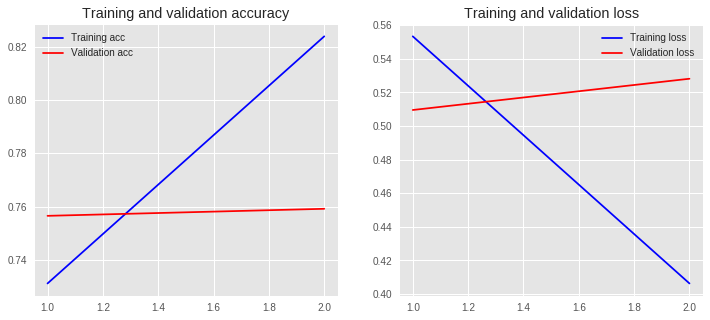

In [0]:
 plot_history(history)

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
y_pred_keras = model.predict(X_test).ravel()
kerasauc = roc_auc_score(y_test, model.predict(X_test).ravel())
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

Logistic Regression model

In [5]:

with open('offenseval-training-v1.tsv', 'r', encoding="utf-8") as f:
    reader = csv.reader(f, dialect='excel', delimiter='\t')
    results = [] #tsv file 0:id, 1:sentence, 2: off/not
    sentences = []
    lables = []
    for row in reader:
        results.append(row)
        sentences.append(row[1])
        lables.append(row[2])
count=0
removal_list = ["@USER","URL"]

for sentence in sentences:
  edit_string_as_list = sentence.split()
  final_list = [word for word in edit_string_as_list if word not in removal_list]
  final_string = ' '.join(final_list)
  final_string = final_string.replace("#", "")
  #final_string = re.sub("^[a-z][a-z\s]*$", "", final_string) #remove non word chars
  sentences[count]=final_string.lower()
  count+=1


y = lables
sentences_train, sentences_test, y_train, y_test = train_test_split( sentences, y, test_size=0.2, random_state=1000)

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_
vectorizer.transform(sentences).toarray()


vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
count=0;
for i in y_train:
  if(i=="OFF"):
    y_train[count]=0
  else:
    y_train[count]=1
  count+=1
count=0;
for i in y_test:
  if(i=="OFF"):
    y_test[count]=0
  else:
    y_test[count]=1
  count+=1
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print( classifier.predict(X_test))
print("Accuracy:", score)
y_pred = classifier.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))




/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0 1 0 ... 1 1 1]
Accuracy: 0.7553793884484711
Accuracy of logistic regression classifier on test set: 0.76


[[ 440  456]
 [ 192 1561]]


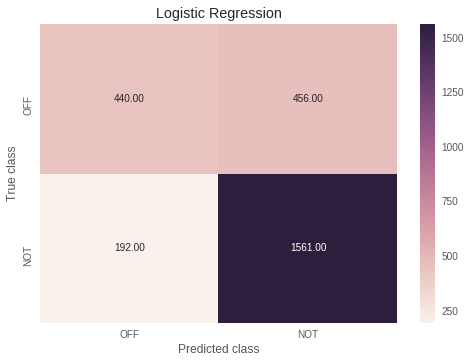

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
logreg_y_pred = y_pred
logreg_cm = metrics.confusion_matrix(y_test,logreg_y_pred, [0,1])
sns.heatmap(logreg_cm, annot=True, fmt='.2f',xticklabels = ["OFF", "NOT"] , yticklabels = ["OFF", "NOT"] )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Logistic Regression')
plt.savefig('logistic_regression')

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.49      0.58       896
           1       0.77      0.89      0.83      1753

   micro avg       0.76      0.76      0.76      2649
   macro avg       0.74      0.69      0.70      2649
weighted avg       0.75      0.76      0.74      2649



In [0]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

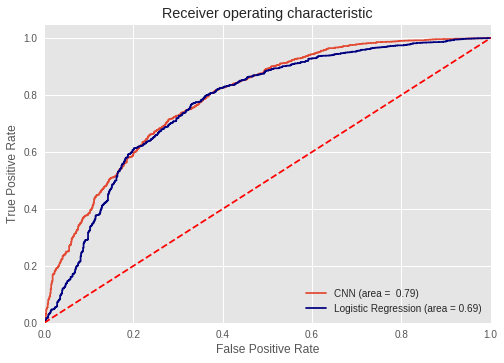

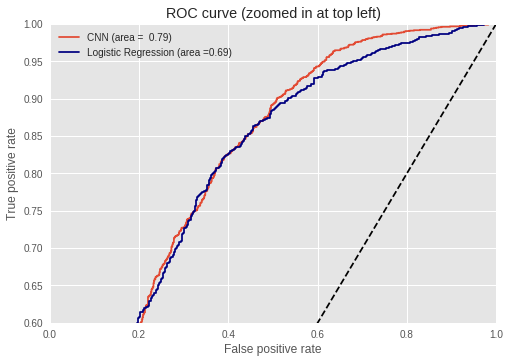

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test,classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
auc_rf = auc(fpr, tpr)
plt.figure(1)
# plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras, tpr_keras, label='CNN (area =  %0.2f)'%kerasauc)
plt.plot(fpr, tpr, color='navy', label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
plt.figure()
plt.xlim(0, 1)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='CNN (area =  %0.2f)'%kerasauc)
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr, tpr,color='navy', label='Logistic Regression (area =%0.2f)'% logit_roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()


K-fold Validation 


In [0]:

with open('offenseval-training-v1.tsv', 'r', encoding="utf-8") as f:
    reader = csv.reader(f, dialect='excel', delimiter='\t')
    results = [] #tsv file 0:id, 1:sentence, 2: off/not
    sentences = []
    lables = []
    for row in reader:
        results.append(row)
        sentences.append(row[1])
        lables.append(row[2])
print(results[1][1])
count=0
removal_list = ["@USER"]
import re
for sentence in sentences:
  edit_string_as_list = sentence.split()
  final_list = [word for word in edit_string_as_list if word not in removal_list]
  final_string = ' '.join(final_list)
  #final_string = re.sub("^[a-z][a-z\s]*$", "", final_string) #remove non word chars
  sentences[count]=final_string.lower()
  count+=1
  
  
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model



# Main settings
epochs = 2
embedding_dim = 100
maxlen = 100
output_file = 'data/output.txt'



# Train-test split
sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, lables, test_size=0.25, random_state=1000)

# Tokenize words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
# Pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
param_grid = dict(num_filters=[190,200,250],
                      kernel_size=[3,4,5],
                      vocab_size=[vocab_size],
                      embedding_dim=[50],
                      maxlen=[maxlen])
model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
test_accuracy = grid.score(X_test, y_test)






@USER She should ask a few native Americans what their take on this is.
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 31.6min finished


In [0]:
print(grid_result.best_score_)
print(grid_result.best_params_)
print(test_accuracy)
print("Testing Accuracy:  {:.4f}".format(test_accuracy))

0.7590130897627136
{'vocab_size': 17963, 'num_filters': 250, 'maxlen': 100, 'kernel_size': 4, 'embedding_dim': 50}
0.7526427070131766
Testing Accuracy:  0.7526
